In [5]:
import numpy as np
import numpy.linalg as LA
from matplotlib import pyplot as plt
import GPy
import csv
import sys
sys.path.append(r"C:\Users\vl385\Documents\casadi-windows-py37-v3.5.1")
from casadi import *
import pickle


In [10]:
class GP:
    def __init__(self, model):
        # Initialize by GPy model or by dictionary containing all information
        if type(model) == GPy.models.gp_regression.GPRegression:
            self.rbf_variance = model.rbf.variance.values[0]
            self.rbf_lengthscale = model.rbf.lengthscale.values
            self.noise_variance = model.Gaussian_noise.variance.values[0]
            self.X = np.array(model.X)
            self.Y = model.Y
        elif type(model) == dict:
            self.rbf_variance = model["rbf_variance"]
            self.rbf_lengthscale = model["rbf_lengthscale"]
            self.noise_variance = model["noise_variance"]
            self.X = model["X_train"]
            self.Y = model["Y_train"]  
            
        self.N = len(self.Y)    
        self.n = np.shape(self.X)[1]
        self.lambda_inv = np.diag(1/self.rbf_lengthscale**2)
        
        x = SX.sym('x', self.n, 1)
        y = SX.sym('y', self.n, 1)
        k_xy = self.rbf_variance**2*exp(-0.5*mtimes([(x-y).T, self.lambda_inv, (x-y)]))
        self.k = Function('k', [x, y], [k_xy])
        
        self.Sigma_inverse()
        
    def Sigma_inverse(self):
        # Pre-compute (K_N + sigma^2*I)^-1 and (K_N + sigma^2*I)^-1*Y
        K_N = np.empty((self.N, self.N))
        for i in range(self.N):
            for j in range(self.N):
                K_N[i,j] = self.se_kernel(self.X[i,:], self.X[j,:])
        self.Sigma_inv = LA.inv(K_N + self.noise_variance**2*np.eye(self.N))
        self.alpha = np.dot(self.Sigma_inv, self.Y) 
    
    def se_kernel(self, x, y):
        if type(x) == np.ndarray and type(y) == np.ndarray:
            return self.k(x, y).full()
        elif type(x) == casadi.SX or type(y) == casadi.SX:
            return self.k(x, y)
                
    def predict(self, p):
        if type(p) == casadi.SX:
            K_star = self.se_kernel(p, p)
            K_xN = self.k.map(self.N) 
            K_star_N = K_xN(p, self.X.transpose())
            K_N_star = K_star_N.T 
            mean = mtimes([K_star_N, self.alpha])
            variance = K_star - mtimes([K_star_N, self.Sigma_inv, K_N_star]) + self.noise_variance**2         
        
        elif type(p) == np.ndarray:
            K_star = self.se_kernel(p, p)
            K_xN = self.k.map(self.N) 
            K_star_N = K_xN(p, self.X.transpose()).full()
            K_N_star = K_star_N.transpose()  
            mean = LA.multi_dot([K_star_N, self.alpha])
            variance = K_star - LA.multi_dot([K_star_N, self.Sigma_inv, K_N_star]) \
                + self.noise_variance**2

        return mean, variance
        

In [12]:
class sparse_GP:
    def __init__(self, model):
        # Initialize by GPy model or by dictionary containing all information
        if type(model) == GPy.models.sparse_gp_regression.SparseGPRegression:
            self.rbf_variance = model.rbf.variance.values[0]
            self.rbf_lengthscale = model.rbf.lengthscale.values
            self.noise_variance = model.Gaussian_noise.variance.values[0]
            self.X = np.array(model.X)
            self.Y = model.Y
            self.Z = model.inducing_inputs.values
        elif type(model) == dict:
            self.rbf_variance = model["rbf_variance"]
            self.rbf_lengthscale = model["rbf_lengthscale"]
            self.noise_variance = model["noise_variance"]
            self.X = model["X_train"]
            self.Y = model["Y_train"]
            self.Z = model["X_ind"]
            
        self.N = len(self.Y)
        self.N_ind = len(self.Z)
        self.n = np.shape(self.X)[1]
        self.lambda_inv = np.diag(1/self.rbf_lengthscale**2)

        x = SX.sym('x', self.n, 1)
        y = SX.sym('y', self.n, 1)
        k_xy = self.rbf_variance**2*exp(-0.5*mtimes([(x-y).T, self.lambda_inv, (x-y)]))
        self.k = Function('k', [x, y], [k_xy])
        
        self.Sigma_inverse()
        
    def Sigma_inverse(self):
        # Pre-compute (K_N + sigma^2*I)^-1        
        self.K_NZ = np.empty((self.N, self.N_ind)) 
        self.K_ZZ = np.empty((self.N_ind, self.N_ind))  
        K_NN = np.empty((self.N, self.N))
        for i in range(self.N):
            for j in range(self.N_ind):
                self.K_NZ[i,j] = self.se_kernel(self.X[i,:], self.Z[j,:])
        for i in range(self.N_ind):
            for j in range(self.N_ind):
                self.K_ZZ[i,j] = self.se_kernel(self.Z[i,:], self.Z[j,:])
        for i in range(self.N):
            for j in range(self.N):
                K_NN[i,j] = self.se_kernel(self.X[i,:], self.X[j,:])
           
        self.K_ZN = self.K_NZ.transpose()
        Q_NN = LA.multi_dot([self.K_NZ, LA.inv(self.K_ZZ), self.K_ZN])
        LAMBDA = np.diag(np.diag(K_NN - Q_NN + self.noise_variance**2*np.eye(self.N)))
        self.Sigma_inv = LA.inv(Q_NN + LAMBDA)
        self.alpha = LA.multi_dot([LA.inv(self.K_ZZ), self.K_ZN, self.Sigma_inv, self.Y]) 
        self.beta = LA.multi_dot([LA.inv(self.K_ZZ), self.K_ZN, self.Sigma_inv, \
                                  self.K_ZN.transpose(), LA.inv(self.K_ZZ).transpose()]) 
    
    def se_kernel(self, x, y):
        if type(x) == np.ndarray and type(y) == np.ndarray:
            return self.k(x, y).full()
        elif type(x) == casadi.SX or type(y) == casadi.SX:
            return self.k(x, y)
                
    def predict(self, p):
        if type(p) == casadi.SX:
            K_xN = self.k.map(self.N_ind) 
            K_star_Z = K_xN(p, self.Z.transpose())
            mean = mtimes(K_star_Z, self.alpha)
            K_star = self.se_kernel(p, p)
            K_Z_star = K_star_Z.T
            variance = K_star - mtimes([K_star_Z, self.beta, K_Z_star]) \
                + self.noise_variance**2       
        
        elif type(p) == np.ndarray:
            K_xN = self.k.map(self.N_ind) 
            K_star_Z = K_xN(p, self.Z.transpose()).full()
            mean = np.dot(K_star_Z, self.alpha)
            K_star = self.se_kernel(p, p)
            K_Z_star = K_star_Z.transpose()
            
            variance = K_star - LA.multi_dot([K_star_Z, self.beta, K_Z_star]) \
                + self.noise_variance**2

        return mean, variance
        

In [13]:
def plot_gp(mu, cov, obs):
    mu = mu.ravel()
    obs = obs.ravel()
    uncertainty = 1.96 * np.sqrt(cov)
    upper = mu + uncertainty.ravel()
    lower = mu - uncertainty.ravel()
    plt.fill_between(np.array(range(0, len(mu))), upper, lower , alpha=0.3)
    plt.plot(mu, label='Mean')
    plt.plot(obs, 'rx')
    plt.legend()

# Preparing data

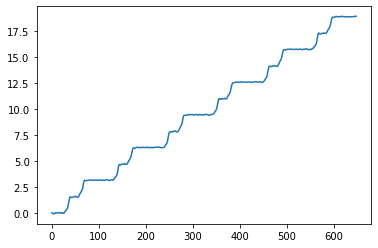

In [16]:
x_list = []
y_list = []
th_list = []
v_list = []
delta_list = []
gt_x_list = []
gt_y_list = []
gt_th_list = []

input_file = "traningdata-2020-05-28-18-56-26.csv"
with open(input_file) as csv_file:
    reader = csv.reader(csv_file)
    for line in reader:
        x_list.append(float(line[0]))
        y_list.append(float(line[1]))
        th_list.append(float(line[2]))
        v_list.append(float(line[3]))
        delta_list.append(float(line[4]))
        gt_x_list.append(float(line[5]))
        gt_y_list.append(float(line[6]))
        gt_th_list.append(float(line[7]))        
N = len(x_list)


for i in range(50,150):
    if th_list[i] < 0:
        th_list[i] = th_list[i] + 2*np.pi
    if gt_th_list[i] < 0:
        gt_th_list[i] = gt_th_list[i] + 2*np.pi
        
for i in range(150,N):
        th_list[i] = th_list[i] + 2*np.pi
        gt_th_list[i] = gt_th_list[i] + 2*np.pi
        
for i in range(250,350):
    if th_list[i] < 2*np.pi:
        th_list[i] = th_list[i] + 2*np.pi
    if gt_th_list[i] < 2*np.pi:
        gt_th_list[i] = gt_th_list[i] + 2*np.pi
        
for i in range(350,N):
        th_list[i] = th_list[i] + 2*np.pi
        gt_th_list[i] = gt_th_list[i] + 2*np.pi
        
for i in range(450,600):
    if th_list[i] < 4*np.pi:
        th_list[i] = th_list[i] + 2*np.pi
    if gt_th_list[i] < 4*np.pi:
        gt_th_list[i] = gt_th_list[i] + 2*np.pi
        
for i in range(600,N):
        th_list[i] = th_list[i] + 2*np.pi
        gt_th_list[i] = gt_th_list[i] + 2*np.pi
        
plt.plot(th_list)
        

In [17]:
dx_list = np.array(x_list[1:]) - np.array(x_list[0:-1])
dy_list = np.array(y_list[1:]) - np.array(y_list[0:-1])
dth_list = np.array(th_list[1:]) - np.array(th_list[0:-1])
v_list = np.array(v_list)
delta_list = np.array(delta_list)
cth_list = np.cos(th_list)
sth_list = np.sin(th_list)

gt_dx_list = np.array(gt_x_list[1:]) - np.array(gt_x_list[0:-1])
gt_dy_list = np.array(gt_y_list[1:]) - np.array(gt_y_list[0:-1])
gt_dth_list = np.array(gt_th_list[1:]) - np.array(gt_th_list[0:-1])
gt_cth_list = np.cos(gt_th_list)
gt_sth_list = np.sin(gt_th_list)
N

649

In [18]:
N_start = 10
N_train = 200
N_test = 200
N_ind = 10
index = np.random.randint(low = 0, high = N_train, size = N_ind)
noise_var = 0.01

## Train GP for Delta_x(k), features are cos(th(k)), sin(th(k)), v(k) and delta(k)

In [19]:
n_feature = 4
Y_train = np.empty([N_train,1])
Y_train[:,0] = gt_dx_list[N_start:N_start+N_train]
X_train = np.empty([N_train,n_feature])
X_train[:,0] = gt_cth_list[N_start:N_start+N_train]
X_train[:,1] = gt_sth_list[N_start:N_start+N_train]
X_train[:,2] = v_list[N_start:N_start+N_train]
X_train[:,3] = delta_list[N_start:N_start+N_train]
# X_train[:,4] = v_list[N_start-1:N_start+N_train-1]
# X_train[:,5] = delta_list[N_start-1:N_start+N_train-1]

X_ind = X_train[index]

In [20]:
Y_test = np.empty([N_test,1])
Y_test[:,0] = gt_dx_list[N_start+N_train:N_start+N_train+N_test]
X_test = np.empty([N_test,n_feature])
X_test[:,0] = gt_cth_list[N_start+N_train:N_start+N_train+N_test]
X_test[:,1] = gt_sth_list[N_start+N_train:N_start+N_train+N_test]
X_test[:,2] = v_list[N_start+N_train:N_start+N_train+N_test]
X_test[:,3] = delta_list[N_start+N_train:N_start+N_train+N_test]
# X_test[:,2] = v_list[N_start+N_train-1:N_start+N_train+N_test-1]
# X_test[:,5] = delta_list[N_start+N_train-1:N_start+N_train+N_test-1]


## Construct GP model

In [21]:
kernel = GPy.kern.RBF(input_dim=n_feature, ARD=True)
m = GPy.models.GPRegression(X_train,Y_train,kernel)
display(m)

GP_regression.,value,constraints,priors
rbf.variance,1.0,+ve,
rbf.lengthscale,"(4,)",+ve,
Gaussian_noise.variance,1.0,+ve,


In [22]:
m.optimize(messages=False)
print(m)


Name : GP regression
Objective : -427.17781378054286
Number of Parameters : 6
Number of Optimization Parameters : 6
Updates : True
Parameters:
  GP_regression.           |                  value  |  constraints  |  priors
  rbf.variance             |     0.1021182391369289  |      +ve      |        
  rbf.lengthscale          |                   (4,)  |      +ve      |        
  Gaussian_noise.variance  |  0.0006006949580468726  |      +ve      |        


In [23]:
mu_s, cov_s = m.predict(X_train)
mu_t, cov_t = m.predict(X_test)

In [24]:
m.rbf.lengthscale.values[1]
m.rbf.variance.values

array([0.10211824])

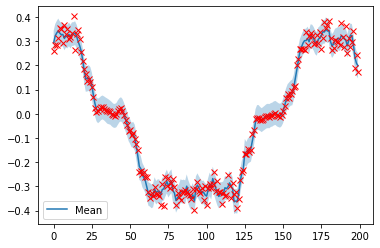

In [25]:
plot_gp(mu_s, cov_s, Y_train)

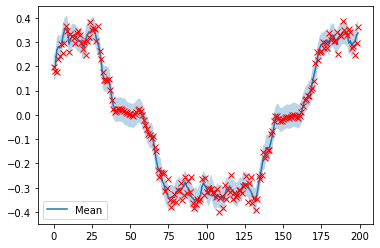

In [26]:
plot_gp(mu_t, cov_t, Y_test)


In [27]:
m.predict(X_train)

(array([[ 0.29399533],
        [ 0.3219831 ],
        [ 0.3338049 ],
        [ 0.34318183],
        [ 0.33337106],
        [ 0.32708562],
        [ 0.32783526],
        [ 0.31148337],
        [ 0.32184691],
        [ 0.31917461],
        [ 0.32803108],
        [ 0.31880356],
        [ 0.32912898],
        [ 0.32982166],
        [ 0.33341434],
        [ 0.32006317],
        [ 0.29862427],
        [ 0.28107483],
        [ 0.25896239],
        [ 0.22175947],
        [ 0.17755618],
        [ 0.14482777],
        [ 0.14519354],
        [ 0.14777773],
        [ 0.13851244],
        [ 0.11515248],
        [ 0.07609347],
        [ 0.04212392],
        [ 0.01917   ],
        [ 0.01199545],
        [ 0.0166587 ],
        [ 0.023467  ],
        [ 0.02627293],
        [ 0.02239742],
        [ 0.01691731],
        [ 0.01159568],
        [ 0.00824336],
        [ 0.00470099],
        [-0.00144611],
        [-0.00729722],
        [-0.0086889 ],
        [-0.00551166],
        [ 0.00528554],
        [ 0

In [28]:
# Save
dictionary = {'X_train': X_train, 'Y_train': Y_train, \
                'rbf_variance': m.rbf.variance.values[0], \
                'rbf_lengthscale': m.rbf.lengthscale.values, \
                'noise_variance': m.Gaussian_noise.variance.values[0]}
pickle.dump(dictionary, open("GP_dx.pkl", "wb"), protocol = 2)

In [29]:
m_dict = pickle.load(open("GP_dx.pkl", "rb"))
gp = GP(m_dict)

## Sparse GP for Delta_x

In [30]:
kernel = GPy.kern.RBF(input_dim=n_feature, ARD=True)
m_sparse = GPy.models.SparseGPRegression(X_train, Y_train, kernel, Z=X_ind)
m_sparse.likelihood.variance = noise_var

In [31]:
m_sparse.randomize()
m_sparse.Z.unconstrain()
m_sparse.optimize('bfgs')

In [32]:
mu_s, cov_s = m_sparse.predict(X_train)
mu_t, cov_t = m_sparse.predict(X_test)

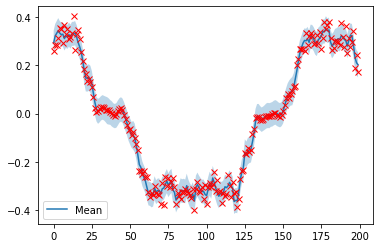

In [33]:
plot_gp(mu_s, cov_s, Y_train)

In [34]:
print(m)
print(m_sparse)


Name : GP regression
Objective : -427.17781378054286
Number of Parameters : 6
Number of Optimization Parameters : 6
Updates : True
Parameters:
  GP_regression.           |                  value  |  constraints  |  priors
  rbf.variance             |     0.1021182391369289  |      +ve      |        
  rbf.lengthscale          |                   (4,)  |      +ve      |        
  Gaussian_noise.variance  |  0.0006006949580468726  |      +ve      |        

Name : sparse_gp
Objective : -423.7168142327355
Number of Parameters : 46
Number of Optimization Parameters : 46
Updates : True
Parameters:
  sparse_gp.               |                  value  |  constraints  |  priors
  inducing_inputs          |                (10, 4)  |               |        
  rbf.variance             |    0.21280264870950347  |      +ve      |        
  rbf.lengthscale          |                   (4,)  |      +ve      |        
  Gaussian_noise.variance  |  0.0006254989688390433  |      +ve      |        


In [35]:
# Save sparse GP
dictionary = {'X_train': X_train, 'Y_train': Y_train, 'X_ind': m_sparse.inducing_inputs.values, \
                'rbf_variance': m_sparse.rbf.variance.values[0], \
                'rbf_lengthscale': m_sparse.rbf.lengthscale.values, \
                'noise_variance': m_sparse.Gaussian_noise.variance.values[0]}
pickle.dump(dictionary, open("sparse_dx.pkl", "wb"), protocol = 2)

In [36]:
m_dict = pickle.load(open("sparse_dx.pkl", "rb"))
gp_dx = sparse_GP(m_dict)

In [37]:
mu_ind = np.zeros(N_train)
for i in range(N_train):
    mu_ind[i] = gp_dx.predict(X_train[i,:])[0]

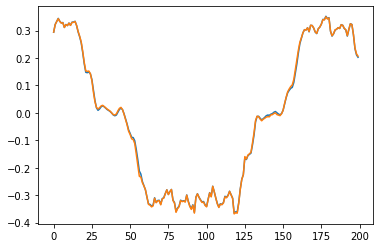

In [38]:
plt.plot(mu_s)
plt.plot(mu_ind)

## Train GP for Delta_y(k), features are cos(th(k)), sin(th(k)), v(k) and delta(k)

In [39]:
n_feature = 4
Y_train = np.empty([N_train,1])
Y_train[:,0] = gt_dy_list[N_start:N_start+N_train]
X_train = np.empty([N_train,n_feature])
X_train[:,0] = gt_cth_list[N_start:N_start+N_train]
X_train[:,1] = gt_sth_list[N_start:N_start+N_train]
X_train[:,2] = v_list[N_start:N_start+N_train]
X_train[:,3] = delta_list[N_start:N_start+N_train]
# X_train[:,4] = v_list[N_start-1:N_start+N_train-1]
# X_train[:,5] = delta_list[N_start-1:N_start+N_train-1]

X_ind = X_train[index]

In [40]:
Y_test = np.empty([N_test,1])
Y_test[:,0] = gt_dy_list[N_start+N_train:N_start+N_train+N_test]
X_test = np.empty([N_test,n_feature])
X_test[:,0] = gt_cth_list[N_start+N_train:N_start+N_train+N_test]
X_test[:,1] = gt_sth_list[N_start+N_train:N_start+N_train+N_test]
X_test[:,2] = v_list[N_start+N_train:N_start+N_train+N_test]
X_test[:,3] = delta_list[N_start+N_train:N_start+N_train+N_test]
# X_test[:,2] = v_list[N_start+N_train-1:N_start+N_train+N_test-1]
# X_test[:,5] = delta_list[N_start+N_train-1:N_start+N_train+N_test-1]


In [41]:
kernel = GPy.kern.RBF(input_dim=n_feature, ARD=True)
m = GPy.models.GPRegression(X_train,Y_train,kernel)
display(m)

GP_regression.,value,constraints,priors
rbf.variance,1.0,+ve,
rbf.lengthscale,"(4,)",+ve,
Gaussian_noise.variance,1.0,+ve,


In [42]:
m.optimize(messages=False)
print(m)


Name : GP regression
Objective : -556.3592797353487
Number of Parameters : 6
Number of Optimization Parameters : 6
Updates : True
Parameters:
  GP_regression.           |                   value  |  constraints  |  priors
  rbf.variance             |     0.08157065325291266  |      +ve      |        
  rbf.lengthscale          |                    (4,)  |      +ve      |        
  Gaussian_noise.variance  |  0.00014016276441362438  |      +ve      |        


In [43]:
mu_s, cov_s = m.predict(X_train)
mu_t, cov_t = m.predict(X_test)

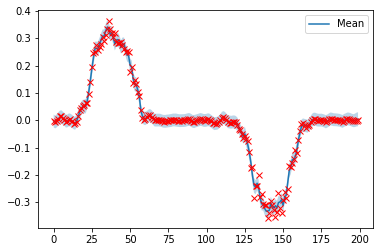

In [44]:
plot_gp(mu_s, cov_s, Y_train)

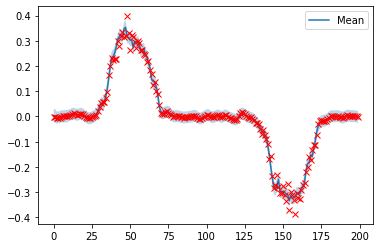

In [45]:
plot_gp(mu_t, cov_t, Y_test)

In [46]:
# Save
dictionary = {'X_train': X_train, 'Y_train': Y_train, \
                'rbf_variance': m.rbf.variance.values[0], \
                'rbf_lengthscale': m.rbf.lengthscale.values, \
                'noise_variance': m.Gaussian_noise.variance.values[0]}
pickle.dump(dictionary, open("GP_dy.pkl", "wb"), protocol = 2)

## Sparse GP for Delta_y

In [47]:
kernel = GPy.kern.RBF(input_dim=n_feature, ARD=True)
m_sparse = GPy.models.SparseGPRegression(X_train, Y_train, kernel, Z=X_ind)
m_sparse.likelihood.variance = noise_var

In [48]:
m_sparse.randomize()
m_sparse.Z.unconstrain()
m_sparse.optimize('bfgs')

In [49]:
mu_s, cov_s = m_sparse.predict(X_train)
mu_t, cov_t = m_sparse.predict(X_test)

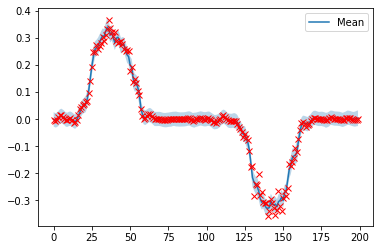

In [50]:
plot_gp(mu_s, cov_s, Y_train)

In [51]:
print(m)
print(m_sparse)


Name : GP regression
Objective : -556.3592797353487
Number of Parameters : 6
Number of Optimization Parameters : 6
Updates : True
Parameters:
  GP_regression.           |                   value  |  constraints  |  priors
  rbf.variance             |     0.08157065325291266  |      +ve      |        
  rbf.lengthscale          |                    (4,)  |      +ve      |        
  Gaussian_noise.variance  |  0.00014016276441362438  |      +ve      |        

Name : sparse_gp
Objective : -537.2879563506176
Number of Parameters : 46
Number of Optimization Parameters : 46
Updates : True
Parameters:
  sparse_gp.               |                  value  |  constraints  |  priors
  inducing_inputs          |                (10, 4)  |               |        
  rbf.variance             |      0.276366411213923  |      +ve      |        
  rbf.lengthscale          |                   (4,)  |      +ve      |        
  Gaussian_noise.variance  |  0.0001760897872423334  |      +ve      |        


In [52]:
# Save sparse GP
dictionary = {'X_train': X_train, 'Y_train': Y_train, 'X_ind': m_sparse.inducing_inputs.values, \
                'rbf_variance': m_sparse.rbf.variance.values[0], \
                'rbf_lengthscale': m_sparse.rbf.lengthscale.values, \
                'noise_variance': m_sparse.Gaussian_noise.variance.values[0]}
pickle.dump(dictionary, open("sparse_dy.pkl", "wb"), protocol = 2)

In [53]:
m_dict = pickle.load(open("sparse_dy.pkl", "rb"))
gp_dy = sparse_GP(m_dict)

In [54]:
mu_ind = np.zeros(N_test)
for i in range(N_train):
    mu_ind[i] = gp_dy.predict(X_test[i,:])[0]

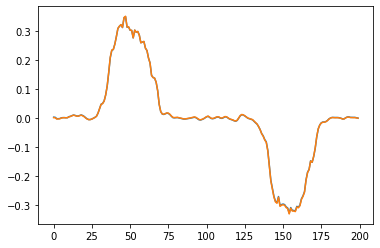

In [55]:
plt.plot(mu_t)
plt.plot(mu_ind)

## Train Delta_th(k), features are v(k) and delta(k)


In [56]:
n_feature = 2
Y_train = np.empty([N_train,1])
Y_train[:,0] = gt_dth_list[N_start:N_start+N_train]
X_train = np.empty([N_train,n_feature])
X_train[:,0] = v_list[N_start:N_start+N_train]
X_train[:,1] = delta_list[N_start:N_start+N_train]

X_ind = X_train[index]

In [57]:
Y_test = np.empty([N_test,1])
Y_test[:,0] = gt_dth_list[N_start+N_train:N_start+N_train+N_test]
X_test = np.empty([N_test,n_feature])
X_test[:,0] = v_list[N_start+N_train:N_start+N_train+N_test]
X_test[:,1] = delta_list[N_start+N_train:N_start+N_train+N_test]


In [58]:
kernel = GPy.kern.RBF(input_dim=n_feature, ARD=True)
m = GPy.models.GPRegression(X_train,Y_train,kernel)
m.optimize(messages=False)
print(m)


Name : GP regression
Objective : -613.3668578339924
Number of Parameters : 4
Number of Optimization Parameters : 4
Updates : True
Parameters:
  GP_regression.           |                  value  |  constraints  |  priors
  rbf.variance             |   0.009327266698516138  |      +ve      |        
  rbf.lengthscale          |                   (2,)  |      +ve      |        
  Gaussian_noise.variance  |  8.760999121773209e-05  |      +ve      |        


In [59]:
mu_s, cov_s = m.predict(X_train)
mu_t, cov_t = m.predict(X_test)

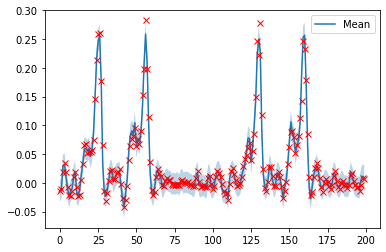

In [60]:
plot_gp(mu_s, cov_s, Y_train)

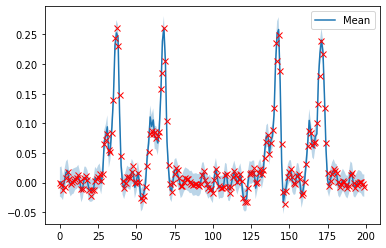

In [61]:
plot_gp(mu_t, cov_t, Y_test)

In [62]:
# Save
dictionary = {'X_train': X_train, 'Y_train': Y_train, \
                'rbf_variance': m.rbf.variance.values[0], \
                'rbf_lengthscale': m.rbf.lengthscale.values, \
                'noise_variance': m.Gaussian_noise.variance.values[0]}
pickle.dump(dictionary, open("GP_dth.pkl", "wb"), protocol = 2)


## Sparse GP for Delta_th

In [63]:
kernel = GPy.kern.RBF(input_dim=n_feature, ARD=True)
m_sparse = GPy.models.SparseGPRegression(X_train, Y_train, kernel, Z=X_ind)
m_sparse.likelihood.variance = noise_var

In [64]:
m_sparse.randomize()
m_sparse.Z.unconstrain()
m_sparse.optimize('bfgs')

In [65]:
mu_s, cov_s = m_sparse.predict(X_train)
mu_t, cov_t = m_sparse.predict(X_test)

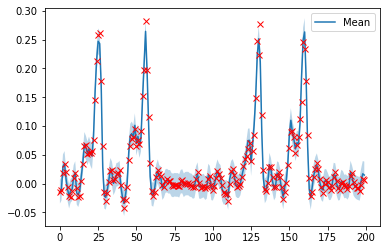

In [66]:
plot_gp(mu_s, cov_s, Y_train)

In [67]:
print(m)
print(m_sparse)


Name : GP regression
Objective : -613.3668578339924
Number of Parameters : 4
Number of Optimization Parameters : 4
Updates : True
Parameters:
  GP_regression.           |                  value  |  constraints  |  priors
  rbf.variance             |   0.009327266698516138  |      +ve      |        
  rbf.lengthscale          |                   (2,)  |      +ve      |        
  Gaussian_noise.variance  |  8.760999121773209e-05  |      +ve      |        

Name : sparse_gp
Objective : -606.0369123116352
Number of Parameters : 24
Number of Optimization Parameters : 24
Updates : True
Parameters:
  sparse_gp.               |                  value  |  constraints  |  priors
  inducing_inputs          |                (10, 2)  |               |        
  rbf.variance             |   0.022708317011983482  |      +ve      |        
  rbf.lengthscale          |                   (2,)  |      +ve      |        
  Gaussian_noise.variance  |  0.0001069976302663049  |      +ve      |        


In [68]:
# Save sparse GP
dictionary = {'X_train': X_train, 'Y_train': Y_train, 'X_ind': m_sparse.inducing_inputs.values, \
                'rbf_variance': m_sparse.rbf.variance.values[0], \
                'rbf_lengthscale': m_sparse.rbf.lengthscale.values, \
                'noise_variance': m_sparse.Gaussian_noise.variance.values[0]}
pickle.dump(dictionary, open("sparse_dth.pkl", "wb"), protocol = 2)

## Try Casadi and GP

In [740]:
M = pickle.load(open("sparse_dx.pkl", "rb"))

In [741]:
M["X_train"]

array([[ 9.99999803e-01,  6.26999959e-04,  1.49773600e+00,
        -2.10420000e-02],
       [ 9.99903355e-01, -1.39025521e-02,  1.70320900e+00,
        -1.11860000e-02],
       [ 9.99698688e-01, -2.45465343e-02,  1.83377200e+00,
         3.53750000e-02],
       [ 9.99979959e-01, -6.33095771e-03,  1.92075100e+00,
         4.04100000e-02],
       [ 9.99603026e-01,  2.81742713e-02,  1.81169100e+00,
         1.11610000e-02],
       [ 9.98861808e-01,  4.76978953e-02,  1.74506200e+00,
        -1.19730000e-02],
       [ 9.99146078e-01,  4.13172354e-02,  1.73736100e+00,
        -3.06000000e-02],
       [ 9.99798885e-01,  2.00546555e-02,  1.62240600e+00,
        -1.65070000e-02],
       [ 9.99995192e-01, -3.10099503e-03,  1.70175600e+00,
        -1.16550000e-02],
       [ 9.99860742e-01, -1.66882253e-02,  1.70095700e+00,
         1.54700000e-02],
       [ 9.99978496e-01, -6.55795299e-03,  1.77596300e+00,
         2.30260000e-02],
       [ 9.99920697e-01,  1.25936671e-02,  1.67282000e+00,
      